In [3]:
import pandas as pd
from ggplot import *

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

project_id = "the-d-team-164512"

query = """\
SELECT
  COUNT(*) AS transaction_count
  , DATE(t.Dispense_Week) AS date
FROM dthon.transactions_all_c2 t
GROUP BY date
ORDER BY date ASC
"""

df_all = pd.read_gbq(query, project_id)
df_all.date = pd.Series(df_all.date).apply(pd.to_datetime, format='%Y-%m-%d')
# df_all = df_all.set_index('date')
df_all.head(3)

Waiting for job to complete...


,transaction_count,date
0,1,2008-03-09
1,1,2008-08-03
2,3,2008-11-02


## So we have a whole lot of drop offs at the transaction volume level which we have cleaned up. Overall the trend is for more transactions steadily growing at ____ TODO what is the rate??

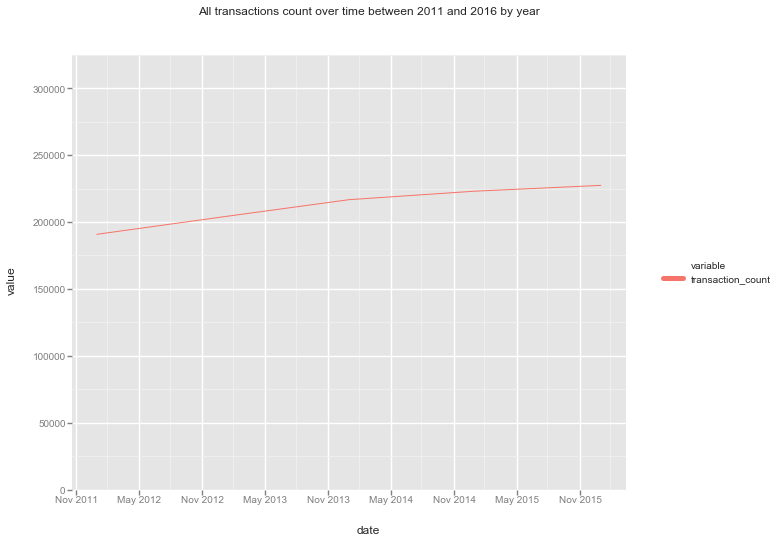

In [35]:
df_tmp = df_all
df_tmp = df_tmp.set_index('date')
df_tmp = df_tmp['2011-01-01' : '2016-01-01']
df_tmp = df_tmp.reset_index()

df_tmp = df_tmp.set_index('date')
df_tmp = df_tmp.resample('A')
df_tmp = df_tmp.reset_index()
df_tmp_ltd = pd.melt(df_tmp, id_vars=['date'])
plot = ggplot(
    aes(x='date', y='value', colour='variable'),
    data=df_tmp_ltd) +\
    labs(title = 'All transactions count over time between 2011 and 2016 by year') +\
    geom_line() +\
    scale_y_continuous(limits=(0,325000))

plot.save('100_all_2011_to_2016_year.svg', width=None, height=None, dpi=180)

# TODO what is the rate here

## What happens now if we look at specific medications?

In [5]:
query = """\
SELECT
  GROUP_CONCAT(UNIQUE(STRING(t.Drug_ID)), ',') AS drug_ids
  , FIRST(d.MasterProductFullName) AS first_drug_name
  , d.BrandName
  , count(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
GROUP BY
  d.BrandName
ORDER BY transaction_count DESC
"""

df_top_drug_by_brand = pd.read_gbq(query, project_id)
df_top_drug_by_brand.head(3)

Waiting for job to complete...


,drug_ids,first_drug_name,d_BrandName,transaction_count
0,"2120,2119,2117,2118",CRESTOR TAB 10MG 30,CRESTOR,1827302
1,6470,PANADOL OSTEO SR-TAB 665MG 96,PANADOL OSTEO,1693547
2,"4869,4867,4860,4861",LIPITOR TAB 20MG 30,LIPITOR,1635951


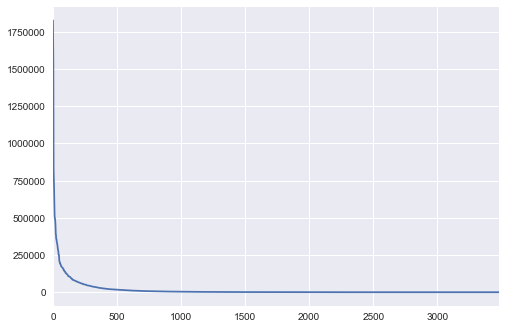

In [6]:
# df_pop_by_year_month.year_month = pd.Series(df_pop_by_year_month.year_month).apply(pd.to_datetime, format='%Y-%m')

# df_pop_by_year_month_lng = pd.melt(df_pop_by_year_month, id_vars=['year_month', 'brand_name'])
# ggplot(
#     aes(x='year_month', y='value', colour='brand_name'),
#     data=df_pop_by_year_month_lng) +\
#     geom_line()
df_top_drug_by_brand['transaction_count'].plot()

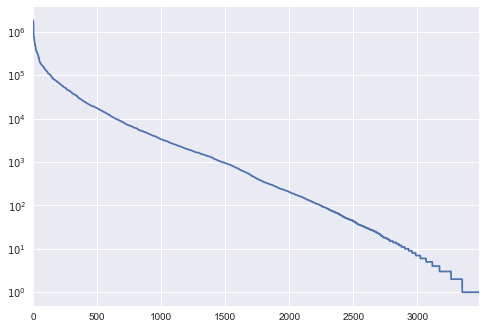

In [7]:
df_top_drug_by_brand['transaction_count'].plot().set_yscale('log')

In [8]:
query = """\
SELECT
  d.BrandName AS brand_name
  , DATE(t.Dispense_Week) AS date
  , COUNT(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
WHERE t.Drug_ID IN ({0})
GROUP BY
  brand_name
  , date
ORDER BY
  brand_name
  , date ASC
"""

query = query.format(",".join(df_top_drug_by_brand['drug_ids'][0 : 100]))
df_pop_over_time = pd.read_gbq(query, project_id)
df_pop_over_time.date = pd.Series(df_pop_over_time.date).apply(pd.to_datetime, format='%Y-%m-%d')
df_pop_over_time.head(3)

Waiting for job to complete...


,brand_name,date,transaction_count
0,ACIMAX,2010-12-26,9
1,ACIMAX,2011-01-02,740
2,ACIMAX,2011-01-09,911


## Looking at the top 100 medications, they seem to be dropping off over time!

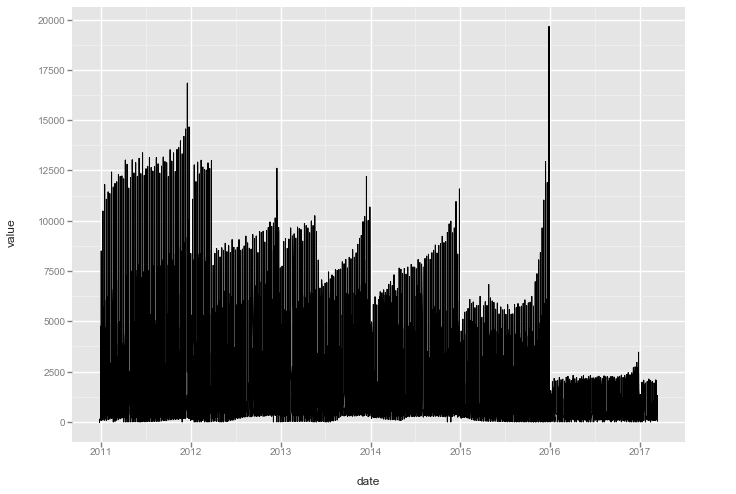

<ggplot: (-9223372036555194080)>

In [60]:
df_tmp = df_pop_over_time
df_tmp_lng = pd.melt(df_tmp, id_vars=['date', 'brand_name'], value_vars=['transaction_count'])
df_tmp_lng
# df_tmp_lng = df_tmp_lng.set_index('date')
# df_tmp_lng = df_tmp_lng['2011-01-01' : '2016-12-31']
# df_tmp_lng = df_tmp_lng.reset_index()

# TODO why does this have post 2016 in it?
ggplot(
    aes(x='date', y='value'),
    data=df_tmp_lng) +\
    geom_line()

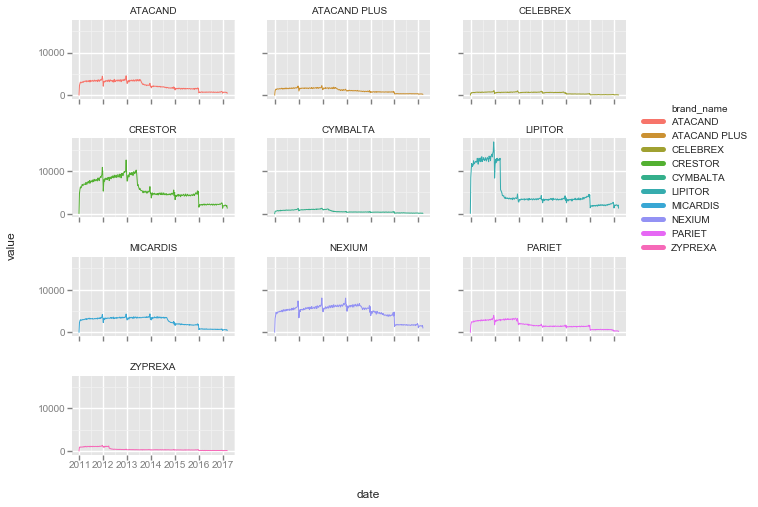

<ggplot: (-9223372036552185463)>

In [58]:
df_tmp = df_pop_over_time
df_tmp_lng = pd.melt(df_tmp, id_vars=['date', 'brand_name'], value_vars=['transaction_count'])
df_tmp_lng
drug_drop_off = ['LIPITOR', 'ZYPREXA', 'SEROQUEL', 'SINGULAIR', 'VIAGRA', 'ARICEPT',
                 'PARIET', 'ATACAND', 'ATACAND PLUS', 'MICARDIS', 'NEXIUM', 'CYMBALTA',
                 'CELEBREX', 'EVISTA', 'CRESTOR']

# TODO would be better to normalize first
ggplot(
    aes(x='date', y='value', colour='brand_name'),
    data=df_tmp_lng[df_tmp_lng['brand_name'].isin(drug_drop_off)]) +\
    geom_line() +\
    facet_wrap("brand_name")

## could look at http://localhost:8888/notebooks/analysis/Going_off_patent.ipynb for more off patent drop offs

## Looking at individual medications we see a lot of drop offs contributing to the over all decline in the most popular medications

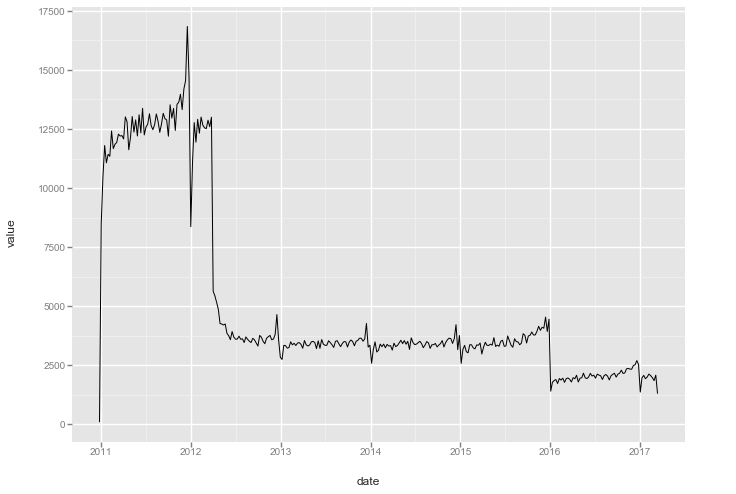

<ggplot: (-9223372036550805090)>


In [62]:
def plot_it(drug_name):
    print(ggplot(
        aes(x='date', y='value'),
        data=df_tmp_lng[df_tmp_lng['brand_name'] == drug_name]) +\
        geom_line())

plot_it('LIPITOR')

## Looking at ATC level we find replacements

In [65]:
query = """\
SELECT
  d.ATCLevel5Code
  , d.BrandName AS brand_name
  , (CASE WHEN d.BrandName = 'LIPITOR' THEN 'LIPITOR' ELSE 'NON LIPITOR' END) AS lipitor
  , DATE(t.Dispense_Week) AS date
  , COUNT(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
WHERE d.ATCLevel5Code = 'C10AA05'
GROUP BY
  d.ATCLevel5Code
  , brand_name
  , lipitor
  , date
ORDER BY
  d.ATCLevel5Code
  , brand_name
  , date ASC
"""
df_rpl = pd.read_gbq(query, project_id)
df_rpl.date = pd.Series(df_rpl.date).apply(pd.to_datetime, format='%Y-%m-%d')
df_rpl.head(3)

Waiting for job to complete...


,d_ATCLevel5Code,brand_name,lipitor,date,transaction_count
0,C10AA05,ATORVACHOL,NON LIPITOR,2012-05-27,24
1,C10AA05,ATORVACHOL,NON LIPITOR,2012-06-03,111
2,C10AA05,ATORVACHOL,NON LIPITOR,2012-06-10,128


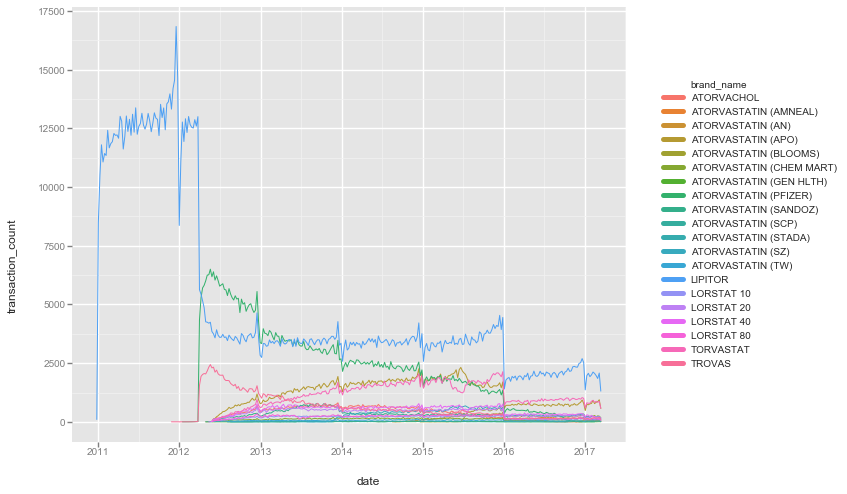

<ggplot: (-9223372036550962877)>

In [68]:
ggplot(
    aes(x='date', y='transaction_count', colour='brand_name'),
    data=df_rpl) +\
    geom_line()

# TODO do this as a stacked chart for plot need to pivot first?
# df_rpl.plot.area(stacked=True, alpha=.3)